In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from darts import TimeSeries, concatenate
from darts.metrics.metrics import mape, mae, mse, ape, ae

In [2]:
from tools.calculate_95_ci import bootstrap_calculate_95_ci
from tools.calculate_metrics import calculate_metrics

Data_loading

In [3]:
location = 'Chiayi' 
model_type = 'LightGBM' 
forecast_horizon ='7' 
num_bootstrap= 1000

location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

In [4]:
#forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_FH{forecast_horizon}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_FH{forecast_horizon}_Bootstrap_metrics.txt')
forecast_series_path = os.path.join(base_dir, f'{location}_{model_type}_FH{forecast_horizon}.csv')
real_series_path = os.path.join('..', 'DataSet', f'EDvisitfile{location}.csv')

In [5]:
forecast_series = pd.read_csv(forecast_series_path, encoding='ISO-8859-1')

In [6]:
real_series = pd.read_csv(real_series_path, encoding='ISO-8859-1')

In [7]:
real_series_subset = real_series[['date', 'No']]

In [8]:
# Create a copy of the subset to avoid the warning
real_series_subset = real_series_subset.copy()

# Convert 'date' column to datetime
real_series_subset['date'] = pd.to_datetime(real_series_subset['date'])

# Set 'date' as the index
real_series_subset.set_index('date', inplace=True)

# Filter the DataFrame for dates starting from '2018-01-01'
real_series_subset = real_series_subset.loc['2018-01-01':]


In [9]:
correct_dates = pd.date_range(start='2018-01-01', periods=len(forecast_series), freq='D')

# Step 2: Replace the 'Date' column with the correct dates
forecast_series['Date'] = correct_dates

# Step 3: Set 'Date' as the index
forecast_series.set_index('Date', inplace=True)

# Step 4: Convert the DataFrame to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(forecast_series, value_cols='No')

In [10]:
combined_series = TimeSeries.from_dataframe(real_series_subset, time_col=None, value_cols='No')

Metric_calculation

In [11]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

In [12]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)

In [13]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)
MAE = mae(combined_series, Model_prediction_ts_inverse)
APE= ape(combined_series, Model_prediction_ts_inverse)
AE = ae(combined_series, Model_prediction_ts_inverse)
APEdf= pd.DataFrame(APE, columns=['APE'])
AEdf = pd.DataFrame(AE, columns=['AE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index
AEdf.index = time_index

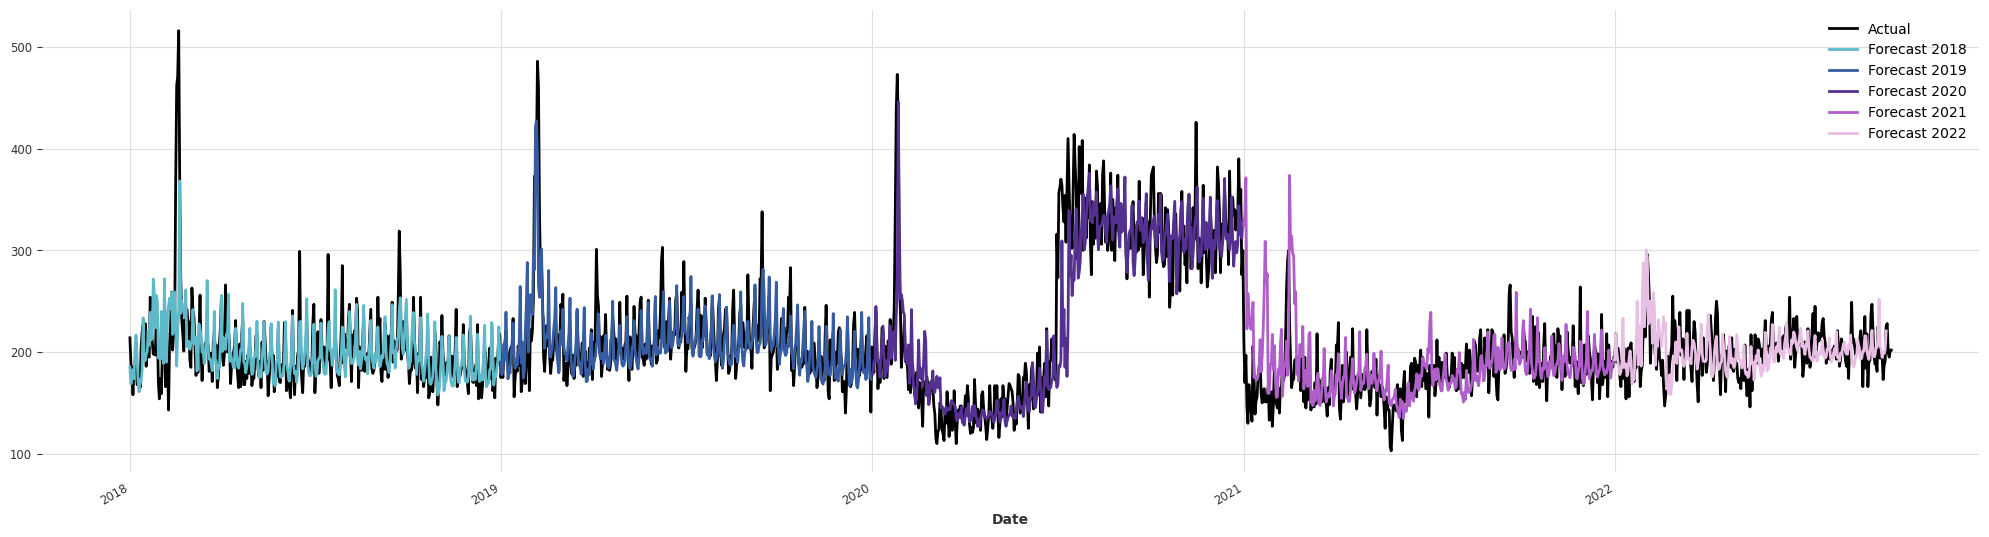

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LightGBM\Chiayi\Chiayi_LightGBM_FH7_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LightGBM\Chiayi\Chiayi_LightGBM_FH7_bootstrap_1000_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LightGBM\Chiayi\Chiayi_LightGBM_FH7.csv


In [14]:
forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_bootstrap_{num_bootstrap}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
combined_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(combined_series, yearly_dataarrays, APEdf, AEdf, bootstrap_calculate_95_ci)  

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n")
        f.write(f"Bootstrap: {num_bootstrap}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'MAE 95% CI':<20} | {'MAPE 95% CI':<20}\n")
        f.write("-" * 95 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            # Correctly assign MAE and MAPE 95% CI
            mae_ci = f"({metric['AE 95% CI'][0]:.2f}, {metric['AE 95% CI'][1]:.2f})" \
                     if isinstance(metric['AE 95% CI'], tuple) else "N/A"
            mape_ci = f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})" \
                      if isinstance(metric['APE 95% CI'], tuple) else "N/A"
            
            # Write the row with corrected order
            f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                    f"{mae_ci:<20} | {mape_ci:<20}\n")
                
    print(f"Metrics saved to {metrics_txt_path}")

else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
#Model_prediction_df_inverse.to_csv(csv_filepath, index=True)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")